In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [16]:
# some adjustments
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [17]:


#from google.colab import files
#uploaded = files.upload()

df_ = pd.read_csv('diabetes.csv')
df = df_.copy()

In [18]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


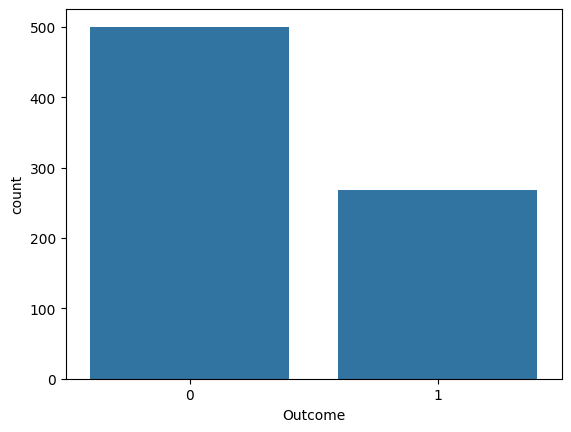

In [19]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


## ... plot here ... ##
p1 = cat_summary(df,'Outcome',plot= True)
p1





                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
Pregnancies              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
Glucose                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BloodPressure            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI                      768.000  31.993   7.884  0.000 21

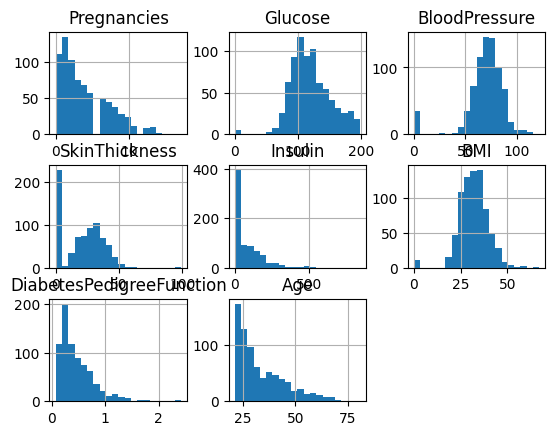

In [20]:

def num_summary(dataframe, numerical_col, plot= False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

## ... plot here ... ##
p2 = num_summary(df, ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'], plot= True)
p2

# Diabetes Risk Modeling

**Objective.** Predict type 2 diabetes risk from clinical measurements.

**Pipeline.** Data cleaning, baseline models, and clinically relevant metrics.

**Evaluation.** ROC-AUC/PR-AUC and decision-threshold trade-offs.


In [21]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

## ....add line here ##
target = target_summary_with_num(df, 'Outcome', 'Age')
target

           Age
Outcome       
0       31.190
1       37.067




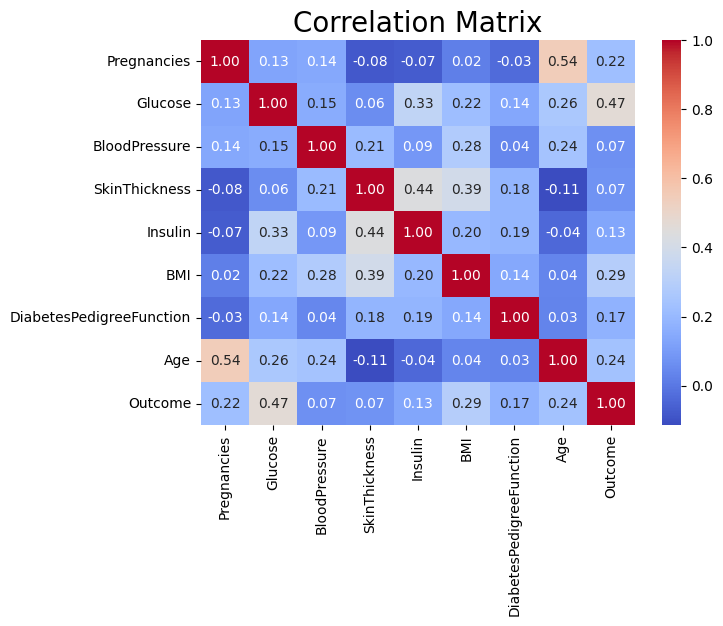

In [22]:
f, ax = plt.subplots(figsize=[7, 5])
## ... add code here ##
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [23]:
## .. add code here ...
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

However, if you look at BLOODPRESSURE (or BMI or INSULIN for example) you can notice some values which do not make any sense.  

In [24]:
## .. replace "??" by the nonsensical value .. ""
(df== 0 ).sum()


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [25]:
df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]]= df[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].replace(0, np.nan) ## add your code here ##

In [26]:
na_cols = df.isna().sum()
na_cols

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [27]:
def median_target(variable):
    temp = df[df[variable].notna()]
    temp = temp[[variable, 'Outcome']].groupby(['Outcome'])[[variable]].median().reset_index()
    return temp

In [30]:



columns = df.columns
columns = columns.drop("Outcome")

for col in columns:

    df.loc[(df['Outcome'] == 0) & (df[col].isna()), col] = median_target(col).loc[median_target(col)['Outcome'] == 0, col].values[0]## add code here
    df.loc[(df['Outcome'] == 1) & (df[col].isna()), col] = median_target(col).loc[median_target(col)['Outcome'] == 1, col].values[0]## add code here


## or just add your own code ##
na_cols = df.isna().sum()
na_cols

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 🤖 3. Model training and evalation

Train/test split

In [32]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


In [34]:
# Standardization for numerical cols
rs = StandardScaler()## ... choose a scaler ##
X_train= rs.fit_transform(X_train)

# Standardize the test data based on the scaler fit on the train data
X_test= rs.transform(X_test)

In [37]:


from sklearn.linear_model import LogisticRegression

## ...import your linear classifier ##
model = LogisticRegression(max_iter=1000, random_state=42)## ... ##
model.fit(X_train,y_train)
## ...train your model ##
#y_pred = ## ... predict on test data ##

y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7792207792207793

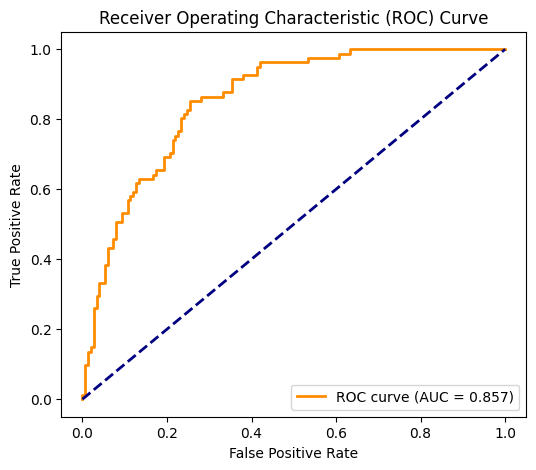

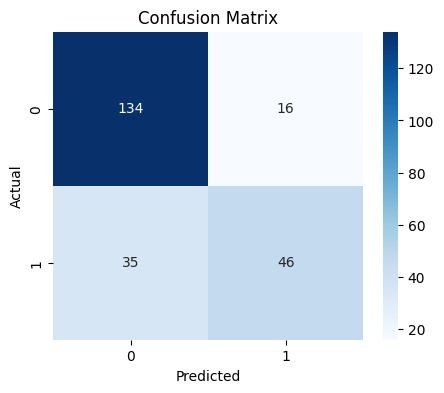

Confusion Matrix:
 [[134  16]
 [ 35  46]]


In [40]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
## Calculate the fpr and tpr for all thresholds of the classification ##

probs = model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
## ... plot a roc curve ##
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## ... plot a another curve? ##


from sklearn.metrics import confusion_matrix
## Get the confusion matrix ##
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Confusion Matrix:\n", cm)
## ... add code here ##




In [43]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
## ... add code here ##
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# trainning
model = SVC(kernel='rbf', probability=True, random_state=17)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
# solution
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8441558441558441

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       150
           1       0.75      0.84      0.79        81

    accuracy                           0.84       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231


Confusion Matrix:
 [[127  23]
 [ 13  68]]


In [45]:

#cross validation
## .. add code here ###
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# difine model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# multiple performance
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# cross validation
scores = {}
for metric_name, scorer in scoring.items():
    score = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    scores[metric_name] = score
    print(f"{metric_name.capitalize()} Scores: {score}")
    print(f"Average {metric_name.capitalize()}: {np.mean(score):.4f}\n")

print("Average performance over 5-fold CV:")
for k, v in scores.items():
    print(f"{k.capitalize()}: {np.mean(v):.4f}")

Accuracy Scores: [0.84415584 0.88311688 0.88961039 0.90849673 0.88235294]
Average Accuracy: 0.8815

F1 Scores: [0.77777778 0.81632653 0.84684685 0.86792453 0.83018868]
Average F1: 0.8278

Precision Scores: [0.77777778 0.90909091 0.8245614  0.86792453 0.83018868]
Average Precision: 0.8419

Recall Scores: [0.77777778 0.74074074 0.87037037 0.86792453 0.83018868]
Average Recall: 0.8174

✅ Average performance over 5-fold CV:
Accuracy: 0.8815
F1: 0.8278
Precision: 0.8419
Recall: 0.8174


## 🗣️ 4. Discussion :